In [3]:
import os
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch

from utils.discrim_training import HideAttackExp
from utils.data import load_Ford_A, transform_data, MyDataset
from models.models import LSTM_net

from utils.attacks import fgsm_disc_attack, fgsm_attack, fgsm_reg_attack

# Discriminator model

In [4]:
def load_experiment(model_name='fgsm_attack_eps=0.03_nsteps=10', device='cpu'):
    with open(fr'results/Ford_A/IFGSM/Regular/Discriminator_pickle/{model_name}/0.pickle', 'rb') as f:
        experiment = pickle.load(f)

    return experiment

In [3]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
experiment = load_experiment(model_name='fgsm_reg_attack_eps=0.03_alpha=0.01_nsteps=10', device=device)

FileNotFoundError: [Errno 2] No such file or directory: 'results/Ford_A/IFGSM/Regular/Discriminator_pickle/fgsm_reg_attack_eps=0.03_alpha=0.01_nsteps=10/0.pickle'

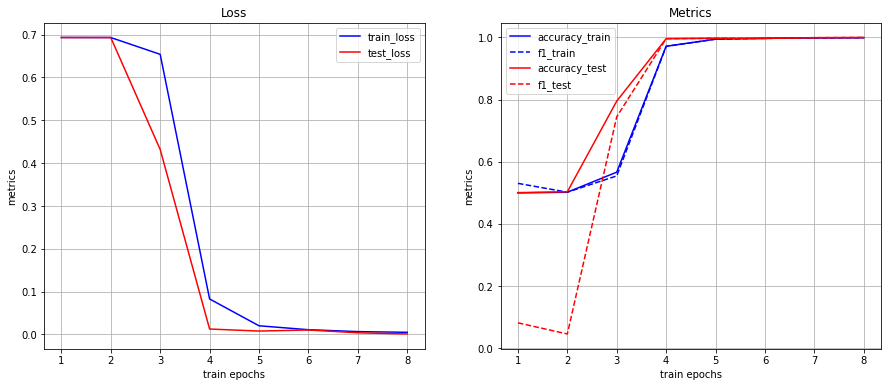

In [ ]:
train_loss = [el.cpu().detach().numpy() for el in experiment.dict_logging['train']['loss']][:8]
test_loss = [el.cpu().detach().numpy() for el in experiment.dict_logging['test']['loss']][:8]

train_accuracy = experiment.dict_logging['train']['accuracy'][:8]
train_f1 = experiment.dict_logging['train']['f1'][:8]
test_accuracy = experiment.dict_logging['test']['accuracy'][:8]
test_f1 = experiment.dict_logging['test']['f1'][:8]

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.title("Loss")
plt.plot(np.arange(len(test_accuracy))+1, train_loss, c='blue', label ='train_loss')
plt.plot(np.arange(len(test_accuracy))+1, test_loss, c='red', label ='test_loss')
plt.grid()
plt.legend()
plt.xlabel('train epochs')
plt.ylabel('metrics')


plt.subplot(1, 2, 2)
plt.title("Metrics")

plt.plot(np.arange(len(train_accuracy))+1, train_accuracy, c='blue', label ='accuracy_train')
plt.plot(np.arange(len(train_accuracy))+1, train_f1, c='blue', linestyle='--', label ='f1_train')
plt.plot(np.arange(len(test_accuracy))+1, test_accuracy, c='red', label ='accuracy_test')
plt.plot(np.arange(len(test_accuracy))+1, test_f1, c='red', linestyle='--', label ='f1_test')
plt.grid()
plt.legend()
plt.xlabel('train epochs')
plt.ylabel('metrics')


plt.show()

# Reg attack analysis

In [5]:
df_loc_test = pd.read_csv(f'results/Ford_A/IFGSM/Regular_Disc/Diff_disc_2/TEST_aa_res_Ford_A_0_alpha=1.csv', index_col=0)
df_loc_orig = pd.read_csv(f'results/Ford_A/IFGSM/Regular_Disc/Diff_disc_2/aa_res_Ford_A_0_alpha=1.csv', index_col=0)

In [6]:
def load_data(name, path='results/Ford_A/Regular_Disc/Same_disc/', model_id=0):

    df_all = pd.DataFrame()

    print(name)

    if name != 'original':
        for alpha in [0, 0.001, 0.01, 0.1, 1, 10, 100]:
            try:
                
                df_loc = pd.read_csv(path + f'aa_res_Ford_A_{model_id}_alpha={alpha}.csv', index_col=0)
                df_loc['method_attack'] = name
                df_loc['alpha'] = alpha
                df_all = pd.concat([df_all, df_loc])
            except:
                pass


    else:
        df_all = pd.read_csv(path + f'aa_res_Ford_A_{model_id}.csv', index_col=0)
        df_all['method_attack'] = 'original'
        df_all['alpha'] = 0

    return df_all

def load_all_datasets(dict_name_path):

    df_all = pd.DataFrame([])

    for name, (path, id) in dict_name_path.items():
        df_loc = load_data(name, path, id)
        df_all = pd.concat([df_all, df_loc])

    return df_all


In [7]:
models_for_viz = {
    'original': ('results/Ford_A/IFGSM/Original/', 0),
    'reg_neigh': ('results/Ford_A/IFGSM/Regular/', 0),
    'reg_disc_same': ('results/Ford_A/IFGSM/Regular_Disc/Same_disc/', 0),
    'reg_disc_diff': ('results/Ford_A/IFGSM/Regular_Disc/Diff_disc/', 0),
    'reg_disc_diff_another': ('results/Ford_A/IFGSM/Regular_Disc/Diff_disc_2/', 0),
    'reg_disc_diff_many_2':('results/Ford_A/IFGSM/Regular_Disc/Diff_disc_many/', 0),
    'reg_disc_diff_many_4':('results/Ford_A/IFGSM/Regular_Disc/Diff_many_4/', 0),
    'ITER_2':('results/Ford_A/IFGSM/Regular_Disc/Disc_reg_iter_2/', 0),
    'ITER_2_BIG_ALPHA':('results/Ford_A/IFGSM/Regular_Disc/Disc_reg_iter_2_BIG_ALPHA/', 0),
    'ITER_3':('results/Ford_A/IFGSM/Regular_Disc/Disc_reg_iter_3/', 0),
    'iter_mix': ('results/Ford_A/IFGSM/Regular_Disc/Disc_reg_mixed_iters/', 0),
    'reg_disc_diff_many_4_id_1':('results/Ford_A/IFGSM/Disc_reg_model_id_1/', 1),
    'DeepFool':('results/Ford_A/DeepFool/Original/', 0),
    }

df_res = load_all_datasets(models_for_viz)
df_res['eps'] = df_res['eps'].round(4)

original
reg_neigh
reg_disc_same
reg_disc_diff
reg_disc_diff_another
reg_disc_diff_many_2
reg_disc_diff_many_4
ITER_2
ITER_2_BIG_ALPHA
ITER_3
iter_mix
reg_disc_diff_many_4_id_1
DeepFool


In [8]:
df_res['eps'].unique()

array([0.001 , 0.0056, 0.0316, 0.1778, 1.    ])

In [9]:
df_res['method_attack'].unique()

array(['original', 'reg_neigh', 'reg_disc_same', 'reg_disc_diff',
       'reg_disc_diff_another', 'reg_disc_diff_many_2',
       'reg_disc_diff_many_4', 'ITER_2', 'ITER_2_BIG_ALPHA', 'ITER_3',
       'iter_mix', 'reg_disc_diff_many_4_id_1', 'DeepFool'], dtype=object)

In [10]:
alpha = 10
eps = df_res.eps.unique()[1]
print('eps: ', eps)
mask_alpha_eps = (df_res['eps'] == eps) & (df_res['alpha'].isin([0, alpha]))

df_filter = df_res[mask_alpha_eps]

eps:  0.0056


In [11]:
style ={
    'original':  {'linestyle':'solid', 'linewidth':1.5, 'color':'black'},
    'reg_neigh':  {'linestyle':'solid', 'linewidth':1.5, 'color':'orange'},
    'reg_disc_same':  {'linestyle':'dotted', 'linewidth':1.5, 'color':'black'},
    #'reg_disc_diff':  {'linestyle':'solid', 'linewidth':1.5, 'color':'black'},
    #'reg_disc_diff_another':  {'linestyle':'solid', 'linewidth':1.5, 'color':'black'},
    #'reg_disc_diff_many_2': {'linestyle':'solid', 'linewidth':1.5, 'color':'black'},
    'reg_disc_diff_many_4': {'linestyle':'dashed', 'linewidth':1.0,},
    'ITER_2': {'linestyle':'dashdot', 'linewidth':1.0, 'color':'green'},
    'ITER_2_BIG_ALPHA': {'linestyle':'dashdot', 'linewidth':1.5, 'color':'green'},
    'ITER_3': {'linestyle':'dashdot', 'linewidth':1.5, 'color':'blue'},
    'iter_mix': {'linestyle':'dashdot', 'linewidth':1.5, 'color':'grey'},
    'reg_disc_diff_many_4_id_1': {'linestyle':'dashed', 'linewidth':1.0, },
    'DeepFool': {'linestyle':'dashed', 'linewidth':1.5, },
    
}

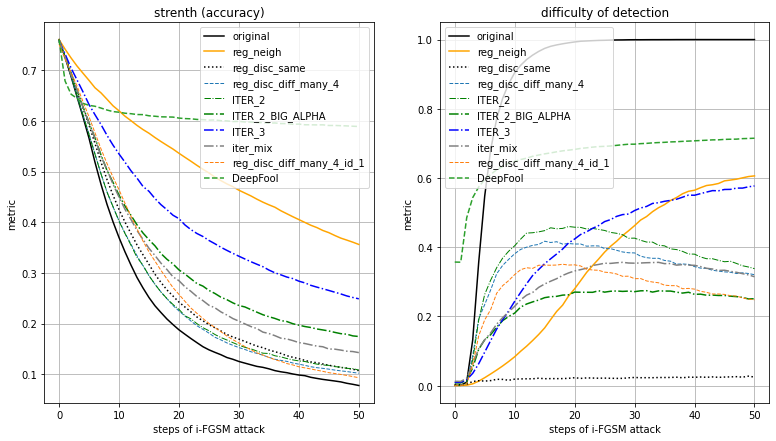

In [12]:
metrics = ['ACC', 'HID']

plt.figure(figsize=(5*len(metrics) + 3, 7))


for i, metric in enumerate(metrics):
    plt.subplot(1, len(metrics), i+1)
    metric_name = 'strenth (accuracy)' if metric == 'ACC' else 'difficulty of detection'
    plt.title(metric_name)
    for method_attack in df_filter['method_attack'].unique():
        if method_attack not in style:
            continue
        df_filter_viz = df_filter[df_filter['method_attack'] == method_attack]
        plt.plot(df_filter_viz['n steps'], df_filter_viz[metric], label=method_attack, 
                 **style[method_attack])

    plt.xlabel('steps of i-FGSM attack')
    plt.ylabel('metric')
    plt.legend()
    plt.grid()
plt.show()


# SimBA

In [10]:
models_for_viz = {
    'original': 'results/Ford_A/SimBA/Original/',
    'reg_neigh': 'results/Ford_A/SimBA/Regular/',
    'reg_disc_diff_many':'results/Ford_A/SimBA/Regular_Disc_diff_many/',
}

df_res = load_all_datasets(models_for_viz)

original
reg_neigh
reg_disc_diff_many


In [15]:
alpha = 1
eps = df_res.eps.unique()[3]
print('eps: ', eps)
mask_alpha_eps = (df_res['eps'] == eps) & (df_res['alpha'].isin([0, alpha]))

df_filter = df_res[mask_alpha_eps]
df_filter

eps:  0.1778279410038923


,n steps,ACC,ROC AUC,PR AUC,HID,eps,method_attack,alpha
0,0,0.760606,0.760334,0.686418,0.480552,0.177828,original,0.0
1,1,0.757727,0.757351,0.683749,0.479420,0.177828,original,0.0
2,2,0.755909,0.755266,0.682795,0.734014,0.177828,original,0.0
3,3,0.751061,0.750162,0.678588,0.840870,0.177828,original,0.0
4,4,0.746136,0.745071,0.673982,0.904671,0.177828,original,0.0
...,...,...,...,...,...,...,...,...
46,46,0.574924,0.572812,0.526795,0.997965,0.177828,reg_disc_diff_many,1.0
47,47,0.571667,0.569582,0.524619,0.997963,0.177828,reg_disc_diff_many,1.0
48,48,0.570076,0.568055,0.523580,0.998031,0.177828,reg_disc_diff_many,1.0
49,49,0.568864,0.566851,0.522782,0.998081,0.177828,reg_disc_diff_many,1.0


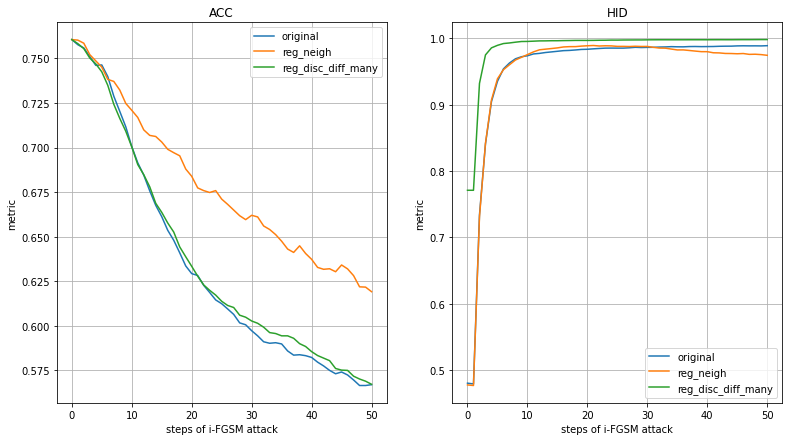

In [16]:
metrics = ['ACC', 'HID']

plt.figure(figsize=(5*len(metrics) + 3, 7))


for i, metric in enumerate(metrics):
    plt.subplot(1, len(metrics), i+1)
    plt.title(metric)
    for method_attack in df_filter['method_attack'].unique():
        df_filter_viz = df_filter[df_filter['method_attack'] == method_attack]
        plt.plot(df_filter_viz['n steps'], df_filter_viz[metric], label=method_attack)

    plt.xlabel('steps of i-FGSM attack')
    plt.ylabel('metric')
    plt.legend()
    plt.grid()
plt.show()


## Hidennes of adversarial attack

In [6]:
df_res.eps.unique()[[1]]

array([0.00562341])

reg_disc_same


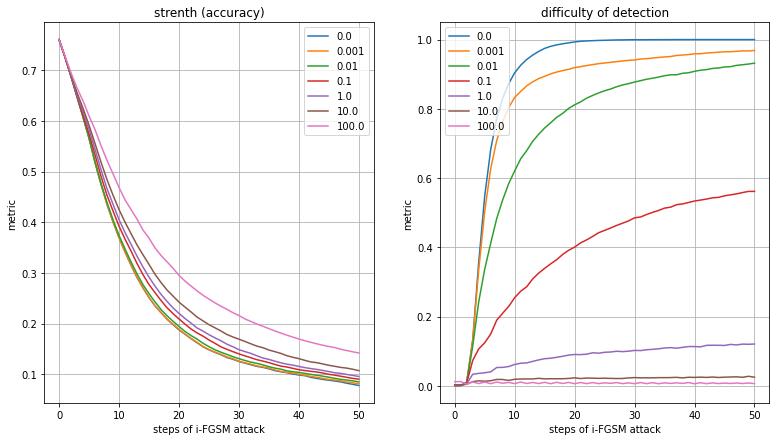

In [13]:
metrics = ['ACC', 'HID']

eps = df_res.eps.unique()[[1]]
methods = ['reg_disc_same', 'original']

mask = (df_res['eps'].isin(eps)) & (df_res['method_attack'].isin(methods))

df_filter = df_res[mask]

print(methods[0])

plt.figure(figsize=(5*len(metrics) + 3, 7))

for i, metric in enumerate(metrics):
    plt.subplot(1, len(metrics), i+1)

    metric_name = 'strenth (accuracy)' if metric == 'ACC' else 'difficulty of detection'
    plt.title(metric_name)
    for alpha in sorted(df_filter['alpha'].unique()):
        df_filter_viz = df_filter[df_filter['alpha'] == alpha]
        plt.plot(df_filter_viz['n steps'], df_filter_viz[metric], label=alpha)

    plt.xlabel('steps of i-FGSM attack')
    plt.ylabel('metric')
    plt.legend()
    plt.grid()
plt.show()

reg


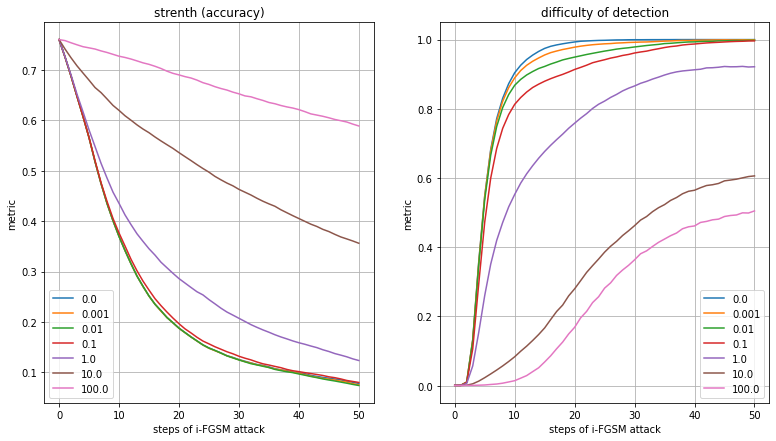

In [14]:
metrics = ['ACC', 'HID']

eps = df_res.eps.unique()[[1]]
methods = ['reg', 'original']
print(methods[0])

mask = (df_res['eps'].isin(eps)) & (df_res['method_attack'].isin(methods))

df_filter = df_res[mask]

plt.figure(figsize=(5*len(metrics) + 3, 7))

for i, metric in enumerate(metrics):
    plt.subplot(1, len(metrics), i+1)

    metric_name = 'strenth (accuracy)' if metric == 'ACC' else 'difficulty of detection'
    plt.title(metric_name)
    for alpha in sorted(df_filter['alpha'].unique()):
        df_filter_viz = df_filter[df_filter['alpha'] == alpha]
        plt.plot(df_filter_viz['n steps'], df_filter_viz[metric], label=alpha)

    plt.xlabel('steps of i-FGSM attack')
    plt.ylabel('metric')
    plt.legend()
    plt.grid()
plt.show()

In [22]:
metrics = ['ACC', 'HID']


plt.figure(figsize=(5*len(metrics) + 3, 7))

for i, alpha in enumerate(df_filter['alpha'].unique()):
    plt.subplot(1, len(metrics), i+1)
    plt.title(metric)
    for method_attack in df_filter['method_attack'].unique():
        df_filter_viz = df_filter[df_filter['method_attack'] == method_attack]
        plt.plot(df_filter_viz['n steps'], df_filter_viz[metric], label=method_attack)

    plt.xlabel('steps of i-FGSM attack')
    plt.ylabel('metric')
    plt.legend()
    plt.grid()
plt.show()

array([0.00562341, 0.17782794])

# Data Visualization

In [235]:
import copy
from tqdm.auto import tqdm


import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F

from models.models import LSTM_net
from utils.data import load_Ford_A, transform_Ford_A, MyDataset
from utils.attacks import fgsm_attack, fgsm_disc_attack
from utils.config import load_disc_config

from utils.discrim_attack import HideAttackExp

from utils.attacks import (fgsm_disc_attack, fgsm_attack, fgsm_reg_attack, 
simba_binary, simba_binary_reg, simba_binary_disc_reg, reg_disc)



In [236]:
X_train, X_test, y_train, y_test = load_Ford_A()
X_train, X_test, y_train, y_test = transform_Ford_A(X_train, X_test, y_train, y_test)

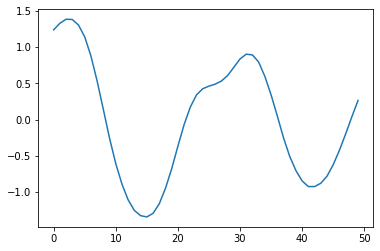

In [275]:
original_object = X_test[3].unsqueeze(0)
plt.plot(original_object[0])

## load attack params

In [276]:
def fgsm_attack(model, loss_func, x, y_true, eps):

    y_pred = model(x)
    y_pred = y_pred.flatten()

    loss_val = loss_func(y_pred, y_true)

    grad_ = torch.autograd.grad(loss_val, x, retain_graph=True)[0]
    x_adv = x.data + eps * torch.sign(grad_)

    return x_adv

    

def fgsm_disc_attack(model, loss_func, x, y_true, eps, alpha, disc_models):

    y_pred = model(x)
    y_pred = y_pred.flatten()
    
    loss_val = loss_func(y_pred, y_true)
    reg_value = reg_disc(x, alpha, disc_models)

    loss = loss_val - reg_value
    grad_ = torch.autograd.grad(loss, x, retain_graph=True)[0]
    x_adv = x.data + eps * torch.sign(grad_)

    return x_adv

def fgsm_reg_attack(model, loss_func, x, y_true, eps, alpha):

    y_pred = model(x)
    y_pred = y_pred.flatten()
    loss_val = loss_func(y_pred, y_true)
    reg_value = reg_neigh(x, alpha)

    loss = loss_val - reg_value
    grad_ = torch.autograd.grad(loss, x, retain_graph=True)[0]
    x_adv = x.data + eps * (torch.sign(grad_))

    return x_adv

def reg_neigh(x, alpha):
            
    x.requires_grad = True
    x_anchor = x[:, 1:-1]
    x_left = x[:, 2:]
    x_right = x[:, :-2]
    x_regular = (x_left + x_right) / 2
    reg_value = torch.sum((x_anchor - x_regular.detach()) ** 2, dim=list(range(1, len(x.shape))))
    reg_value = alpha * torch.mean(reg_value)
    return reg_value


def reg_disc(x, alpha: float, disc_models):
    n_models = len(disc_models)
    reg_value = 0
    for d_model in disc_models:
        x.grad = None
        x.requires_grad = True
        
        req_grad(d_model, state=False)
        d_model.train(True)
        reg_value = reg_value + torch.mean(torch.log(F.sigmoid(d_model(x))))

    reg_value = alpha* reg_value / n_models
    return reg_value

def req_grad(model, state: bool = True) -> None:
    for param in model.parameters():
        param.requires_grad_(state)

In [277]:
cfg = {
    'model_folder':'checkpoints/Ford_A/',
    'model_id_attack': 0,
    'disc_path': 'results/Ford_A/IFGSM/Regular/Discriminator_pickle',
    'list_reg_model_params': [
        {'model_id':0, 'model_name':'fgsm_reg_attack_eps=0.03_alpha=0.01_nsteps=10'},
        {'model_id':0, 'model_name':'fgsm_reg_attack_eps=0.03_alpha=0.1_nsteps=10'},
        {'model_id':0, 'model_name':'fgsm_reg_attack_eps=0.03_alpha=0.01_nsteps=10'},
        {'model_id':0, 'model_name':'fgsm_reg_attack_eps=0.03_alpha=0.1_nsteps=10'},
     ],

}

device = 'cuda:1'
loss_func = torch.nn.BCELoss()

model = LSTM_net(hidden_dim = 50, n_layers = 1, output_dim = 1, dropout=0.0).to(device)
model_path = cfg['model_folder'] + f'model_{cfg["model_id_attack"]}_FordA.pth'
model.load_state_dict(copy.deepcopy(torch.load(model_path)))

x = copy.deepcopy(original_object).unsqueeze(-1).to(device)
y = y_test[0].to(torch.float).to(device)
eps = 0.2
alpha = 10.0

disc_models = load_disc_config(cfg['disc_path'], device, cfg['list_reg_model_params'])  

In [278]:
n_iterations = 50

x_attack = copy.deepcopy(x)
x_reg_attack = copy.deepcopy(x)
x_disc_attack = copy.deepcopy(x)

for iter_ in tqdm(range(n_iterations)):

    x_attack.grad = None
    x_attack.requires_grad = True

    x_reg_attack.grad = None
    x_reg_attack.requires_grad = True

    x_disc_attack.grad = None
    x_disc_attack.requires_grad = True

    x_attack = fgsm_attack(model, loss_func, x_attack, y, eps)
    x_reg_attack = fgsm_reg_attack(model, loss_func, x_reg_attack, y, eps, alpha)
    x_disc_attack = fgsm_disc_attack(model, loss_func, x_disc_attack, y, eps, alpha, disc_models)


  0%|          | 0/50 [00:00<?, ?it/s]

/cephfs/projects/psoker/.local/lib/python3.8/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


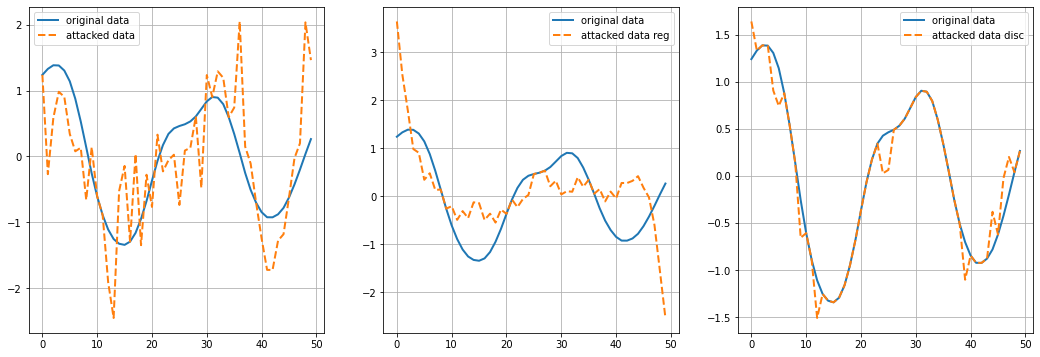

In [279]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(original_object[0], label='original data', lw=2)
plt.plot(x_attack.cpu().detach().flatten(), label='attacked data', lw=2, linestyle='--')
plt.legend()
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(original_object[0], label='original data', lw=2)
plt.plot(x_reg_attack.cpu().detach().flatten(), label='attacked data reg',lw=2, linestyle='--')
plt.legend()
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(original_object[0], label='original data', lw=2)
plt.plot(x_disc_attack.cpu().detach().flatten(), label='attacked data disc', lw=2, linestyle='--')
plt.legend()
plt.grid()

plt.show()

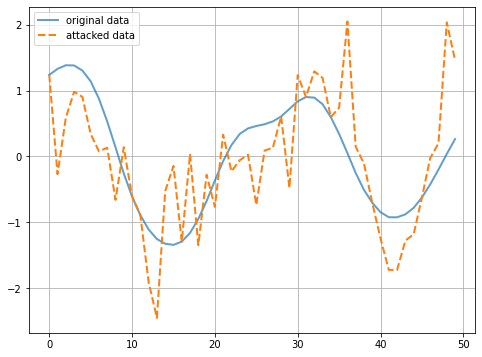

In [287]:
plt.figure(figsize=(8, 6))

plt.plot(original_object[0], label='original data', lw=2, alpha=0.7)
plt.plot(x_attack.cpu().detach().flatten(), label='attacked data', lw=2, linestyle='--')
# plt.plot(x_reg_attack.cpu().detach().flatten(), label='attacked neighbor data ',lw=2, linestyle='dashdot')
# plt.plot(x_disc_attack.cpu().detach().flatten(), label='attacked data discriminator reg', lw=2, linestyle=':')
plt.legend()
plt.grid()

plt.show()